# Currency Predictor (Python and Time Series Analysis)

## Background

### Why this project?
Recognizing that large companies often deal with foreign currency transactions while doing international business, and as a result, they are always looking for anything that can help them better understand the future direction and risk of various currencies. In this exercise, I will predict future movements in the value of the Japanese yen versus the U.S. dollar.

### What skills does this emphasis?
- Python
- Scikit-learn
- Statsmodels
- Pandas
- Linear Regression
- SGD Regression
- Extreme Gradient Boosting Regression
- Bagging Regression
- Random Forest Regression
- Forecasting
- CSV
- Time-Series Analysis

### Objectives
1. Use Python packages to run financial analysis on the data I retrieve
2. Use time-series models to identify predictable patterns in short-term trends and seasonality of currency
3. Incorporate useful explanatory data into the predictive models, such as information on weather and physical commodity production

## Code

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import datetime
import xgboost
from xgboost import XGBRegressor, DMatrix
from statsmodels.tsa.seasonal import seasonal_decompose

### Read and Manipulate Historical Data

In [2]:
#Read in Historical Data
dataset = pd.read_csv('USD_JPY Historical Data.csv')

#Convert Dates to Datetime format and set that as the index
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.set_index('Date')
dataset = dataset.sort_index()

#Convert Change % from string to float
dataset['Change %'] = dataset["Change %"].str.replace(r"[^0-9.-]",'').astype(float)
dataset['Change %'] = dataset["Change %"]/100

<ipython-input-2-5a6b53079f87>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['Change %'] = dataset["Change %"].str.replace(r"[^0-9.-]",'').astype(float)


In [3]:
print(dataset.head())

             Price    Open    High     Low  Change %
Date                                                
2003-01-17  117.75  117.80  118.20  117.37   -0.0009
2003-01-20  118.00  117.94  118.36  117.84    0.0021
2003-01-21  118.15  118.05  119.18  117.96    0.0013
2003-01-22  118.34  118.08  118.57  117.93    0.0016
2003-01-23  118.07  118.20  118.85  117.63   -0.0023


In [4]:
print(dataset.tail())

             Price    Open    High     Low  Change %
Date                                                
2021-12-08  113.66  113.58  113.96  113.31    0.0008
2021-12-09  113.44  113.68  113.82  113.27   -0.0019
2021-12-10  113.38  113.52  113.81  113.22   -0.0005
2021-12-12  113.51  113.28  113.52  113.28    0.0012
2021-12-13  113.49  113.51  113.74  113.39   -0.0002


#### Check for Nulls

In [5]:
print(dataset.isna().sum())

Price       0
Open        0
High        0
Low         0
Change %    0
dtype: int64


#### Plot Data

No handles with labels found to put in legend.


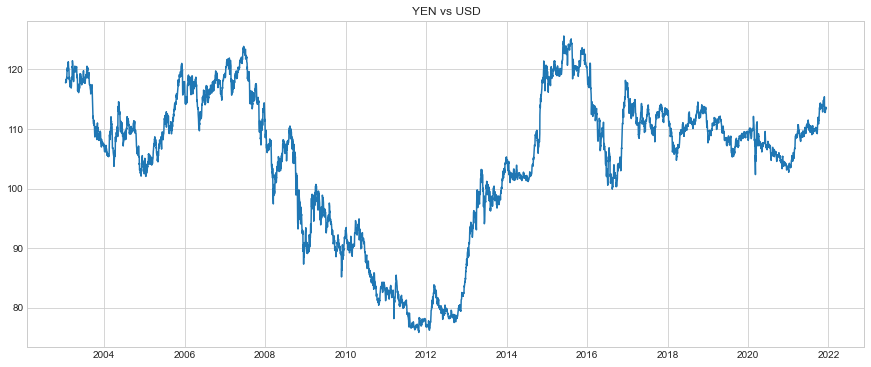

In [6]:
plt.figure(figsize=(15,6))
plt.plot(dataset.Price)
plt.title('YEN vs USD')
plt.legend()
plt.show()

### Objective 1
Use Python packages to run financial analysis on the data I retrieve

#### Create a Boxplot for Price, Open, High, and Low

<AxesSubplot:>

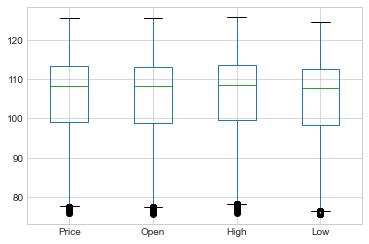

In [7]:
dataset.drop('Change %', axis=1).boxplot()

#### Create a Boxplot for Change %

<AxesSubplot:>

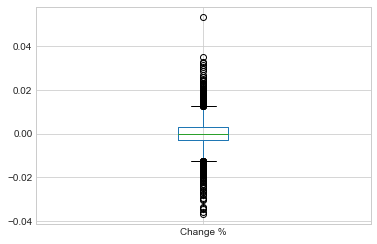

In [8]:
dataset[['Change %']].boxplot()

#### Create New Features for Analysis

In [9]:
featureData = pd.DataFrame()

#Add Original Features
featureData['Price'] = dataset['Price']
featureData['Open'] = dataset['Open']

#Add Day Before Features
featureData['Price_DB'] = dataset['Price'].shift(1)
featureData['Open_DB'] = dataset['Open'].shift(1)
featureData['High_DB'] = dataset['High'].shift(1)
featureData['Low_DB'] = dataset['Low'].shift(1)

#Add Price Average Windows
featureData['Price_Average_Week'] = dataset['Price'].rolling(window=5).mean().shift(1)
featureData['Price_Average_Month'] = dataset['Price'].rolling(window=21).mean().shift(1)
featureData['Price_Average_3Month'] = dataset['Price'].rolling(window=63).mean().shift(1)
featureData['Price_Average_Year'] = dataset['Price'].rolling(window=252).mean().shift(1)

#Add Price Average Ratios
featureData['Price_AVGRatio_Week_Month'] = featureData['Price_Average_Week']/featureData['Price_Average_Month']
featureData['Price_AVGRatio_Week_3Month'] = featureData['Price_Average_Week']/featureData['Price_Average_3Month']
featureData['Price_AVGRatio_Week_Year'] = featureData['Price_Average_Week']/featureData['Price_Average_Year']
featureData['Price_AVGRatio_Month_3Month'] = featureData['Price_Average_Month']/featureData['Price_Average_3Month']
featureData['Price_AVGRatio_Month_Year'] = featureData['Price_Average_Month']/featureData['Price_Average_Year']
featureData['Price_AVGRatio_3Month_Year'] = featureData['Price_Average_3Month']/featureData['Price_Average_Year']

#Add Price Standard Deviations
featureData['Price_STD_Week'] = dataset['Price'].rolling(window=5).std().shift(1)
featureData['Price_STD_Month'] = dataset['Price'].rolling(window=21).std().shift(1)
featureData['Price_STD_3Month'] = dataset['Price'].rolling(window=63).std().shift(1)
featureData['Price_STD_Year'] = dataset['Price'].rolling(window=252).std().shift(1)

#Add Price Standard Deviations Ratios
featureData['Price_STDRatio_Week_Month'] = featureData['Price_STD_Week']/featureData['Price_STD_Month']
featureData['Price_STDRatio_Week_3Month'] = featureData['Price_STD_Week']/featureData['Price_STD_3Month']
featureData['Price_STDRatio_Week_Year'] = featureData['Price_STD_Week']/featureData['Price_STD_Year']
featureData['Price_STDRatio_Month_3Month'] = featureData['Price_STD_Month']/featureData['Price_STD_3Month']
featureData['Price_STDRatio_Month_Year'] = featureData['Price_STD_Month']/featureData['Price_STD_Year']
featureData['Price_STDRatio_3Month_Year'] = featureData['Price_STD_3Month']/featureData['Price_STD_Year']

#Add Daily, Weekly, Monthly, Quarterly, and Yearly Returns
featureData['Day_Return'] = ((dataset['Price']-dataset['Price'].shift(1))/dataset['Price'].shift(1)).shift(1)
featureData['Week_Return'] = ((dataset['Price']-dataset['Price'].shift(5))/dataset['Price'].shift(5)).shift(1)
featureData['Month_Return'] = ((dataset['Price']-dataset['Price'].shift(21))/dataset['Price'].shift(21)).shift(1)
featureData['Quarter_Return'] = ((dataset['Price']-dataset['Price'].shift(63))/dataset['Price'].shift(63)).shift(1)
featureData['Year_Return'] = ((dataset['Price']-dataset['Price'].shift(252))/dataset['Price'].shift(252)).shift(1)

#Add Average of Daily Return
featureData['Day_Return_Week_AVG'] = featureData['Day_Return'].rolling(window=5).mean()
featureData['Day_Return_Month_AVG'] = featureData['Day_Return'].rolling(window=21).mean()
featureData['Day_Return_3Month_AVG'] = featureData['Day_Return'].rolling(window=63).mean()
featureData['Day_Return_Year_AVG'] = featureData['Day_Return'].rolling(window=252).mean()

featureData = featureData.dropna(axis=0)

In [10]:
featureData.head()

,Price,Open,Price_DB,Open_DB,High_DB,Low_DB,Price_Average_Week,Price_Average_Month,Price_Average_3Month,Price_Average_Year,...,Price_STDRatio_3Month_Year,Day_Return,Week_Return,Month_Return,Quarter_Return,Year_Return,Day_Return_Week_AVG,Day_Return_Month_AVG,Day_Return_3Month_AVG,Day_Return_Year_AVG
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-07,106.23,106.17,106.21,106.26,106.43,106.03,106.876,107.366667,108.476190,115.572817,...,0.222906,-0.000565,-0.008032,-0.010435,-0.027114,-0.098004,-0.001605,-0.000493,-0.000423,-0.000397
2004-01-08,106.19,106.15,106.23,106.17,106.45,105.88,106.648,107.331429,108.437619,115.526111,...,0.229387,0.000188,-0.010617,-0.006918,-0.022363,-0.099746,-0.002128,-0.000324,-0.000346,-0.000405
2004-01-09,106.61,106.13,106.19,106.15,106.26,106.08,106.392,107.232857,108.394444,115.478651,...,0.235209,-0.000377,-0.011910,-0.019121,-0.024975,-0.101227,-0.002389,-0.000916,-0.000389,-0.000411
2004-01-12,106.71,106.64,106.61,106.13,108.27,106.11,106.302,107.163810,108.358095,115.432103,...,0.238110,0.003955,-0.004203,-0.013418,-0.021028,-0.099121,-0.000835,-0.000640,-0.000325,-0.000402
2004-01-13,106.23,106.64,106.71,106.64,106.77,106.35,106.390,107.114286,108.313333,115.387024,...,0.238496,0.000938,0.004140,-0.009652,-0.025746,-0.096214,0.000828,-0.000459,-0.000401,-0.000389


In [11]:
featureData.tail()

,Price,Open,Price_DB,Open_DB,High_DB,Low_DB,Price_Average_Week,Price_Average_Month,Price_Average_3Month,Price_Average_Year,...,Price_STDRatio_3Month_Year,Day_Return,Week_Return,Month_Return,Quarter_Return,Year_Return,Day_Return_Week_AVG,Day_Return_Month_AVG,Day_Return_3Month_AVG,Day_Return_Year_AVG
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-08,113.66,113.58,113.57,113.46,113.79,113.39,113.146,113.919524,112.769365,109.306627,...,0.564147,0.000970,0.003889,0.003091,0.035278,0.099313,0.000783,0.000163,0.000560,0.000382
2021-12-09,113.44,113.68,113.66,113.58,113.96,113.31,113.328,113.958095,112.828571,109.347738,...,0.554595,0.000792,0.008071,0.007178,0.033931,0.100290,0.001613,0.000356,0.000539,0.000385
2021-12-10,113.38,113.52,113.44,113.68,113.82,113.27,113.386,113.936190,112.883492,109.386667,...,0.543867,-0.001936,0.002563,-0.004039,0.031460,0.094664,0.000517,-0.000179,0.000501,0.000365
2021-12-12,113.51,113.28,113.38,113.52,113.81,113.22,113.502,113.904286,112.942381,109.425675,...,0.529060,-0.000529,0.005142,-0.005875,0.033829,0.094930,0.001030,-0.000267,0.000537,0.000366
2021-12-13,113.49,113.51,113.51,113.28,113.52,113.28,113.512,113.888095,113.008254,109.464881,...,0.509086,0.001147,0.000441,-0.002986,0.037948,0.095339,0.000089,-0.000129,0.000600,0.000367


In [12]:
featureData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4680 entries, 2004-01-07 to 2021-12-13
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        4680 non-null   float64
 1   Open                         4680 non-null   float64
 2   Price_DB                     4680 non-null   float64
 3   Open_DB                      4680 non-null   float64
 4   High_DB                      4680 non-null   float64
 5   Low_DB                       4680 non-null   float64
 6   Price_Average_Week           4680 non-null   float64
 7   Price_Average_Month          4680 non-null   float64
 8   Price_Average_3Month         4680 non-null   float64
 9   Price_Average_Year           4680 non-null   float64
 10  Price_AVGRatio_Week_Month    4680 non-null   float64
 11  Price_AVGRatio_Week_3Month   4680 non-null   float64
 12  Price_AVGRatio_Week_Year     4680 non-null   float64
 13  

<AxesSubplot:>

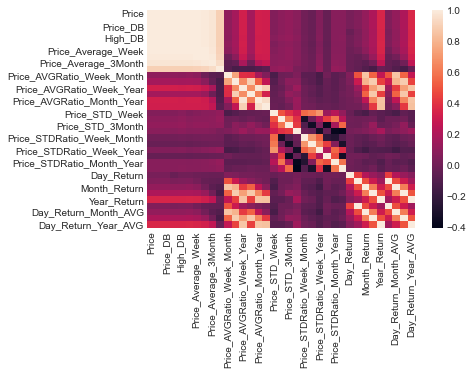

In [13]:
sns.heatmap(featureData.corr())

### Objective 2
Use time-series models to identify predictable patterns in short-term trends and seasonality of currency

#### Check for Seasonality

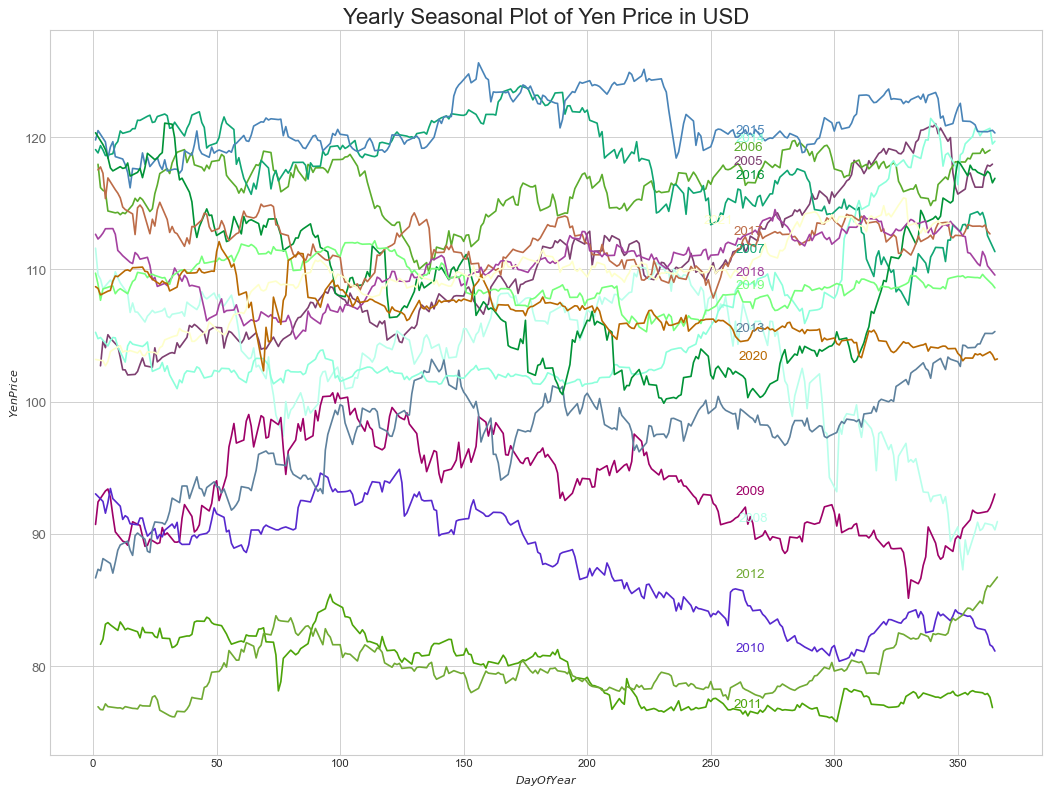

In [14]:
#Prepare Data for Year Plot
exploreData = pd.DataFrame()
exploreData["Price"] = featureData["Price"]
exploreData['Year'] = [d.year for d in exploreData.index]

exploreData['DayofYear'] = [d.strftime('%j') for d in exploreData.index]
exploreData['DayofYear'] = exploreData['DayofYear'].astype(int)
years = exploreData["Year"].unique()

#Set Up Colors
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

#Draw Plot
plt.figure(figsize=(16,12), dpi=80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('DayofYear', 'Price', data=exploreData.loc[exploreData.Year==y, :], color=colors[i], label=y)
        plt.text(exploreData.loc[exploreData.Year==y, :].shape[0]-.9, exploreData.loc[exploreData.Year==y, 'Price'][-1:].values[0], y, fontsize=12, color=colors[i])

#Decoration
plt.gca().set(ylabel='$Yen Price$', xlabel='$DayOfYear$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Yearly Seasonal Plot of Yen Price in USD", fontsize=20)
plt.show()



<AxesSubplot:>

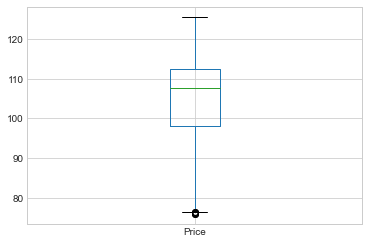

In [15]:
#Prepare Data for Month Plots
exploreData = featureData.copy()
exploreData['Month'] = [d.month for d in exploreData.index]
months = exploreData["Month"].unique()

#All Data BoxPlot
exploreData[["Price"]].boxplot()

<AxesSubplot:>

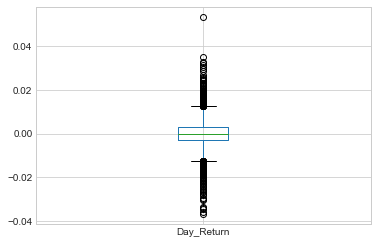

In [16]:
exploreData[["Day_Return"]].boxplot()

<AxesSubplot:>

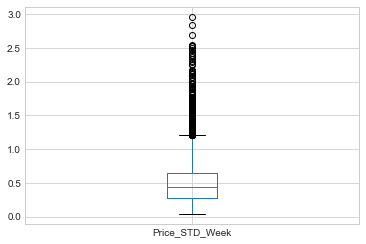

In [17]:
exploreData[["Price_STD_Week"]].boxplot()

<AxesSubplot:title={'center':'Price'}, xlabel='Month'>

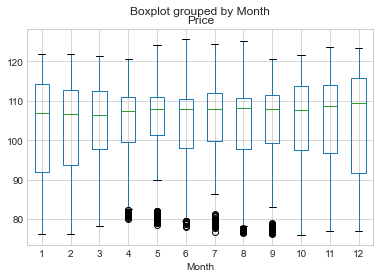

In [18]:
#Per Month BoxPlots
exploreData.boxplot(column="Price", by="Month")

<AxesSubplot:title={'center':'Day_Return'}, xlabel='Month'>

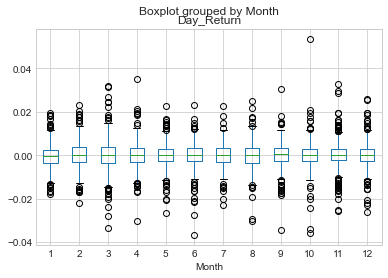

In [19]:
exploreData.boxplot(column="Day_Return", by="Month")

<AxesSubplot:title={'center':'Price_STD_Week'}, xlabel='Month'>

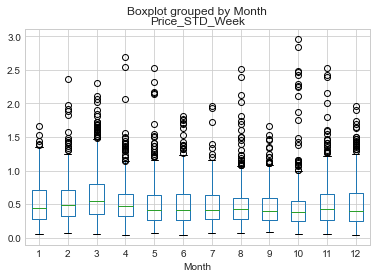

In [20]:
exploreData.boxplot(column="Price_STD_Week", by="Month")

**Here it is tough to see if there is any consistent seasonality, but by decomposing the dataset, I can find out for sure**

##### Period=5

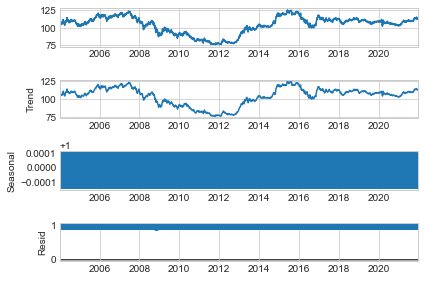

In [21]:
analysisData = pd.DataFrame()
analysisData["Price"] = exploreData['Price'] 
decompose_result_mult = seasonal_decompose(analysisData, period=5, model="muliplicitive")
decompose_result_mult.plot();

##### Period=21

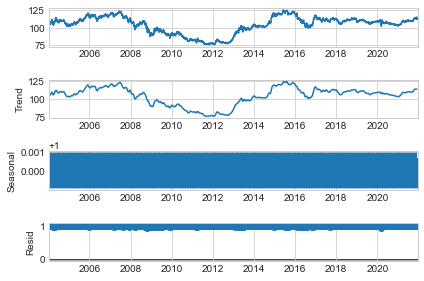

In [22]:
analysisData = pd.DataFrame()
analysisData["Price"] = exploreData['Price'] 
decompose_result_mult = seasonal_decompose(analysisData, period=21, model="muliplicitive")
decompose_result_mult.plot();

##### Period=253

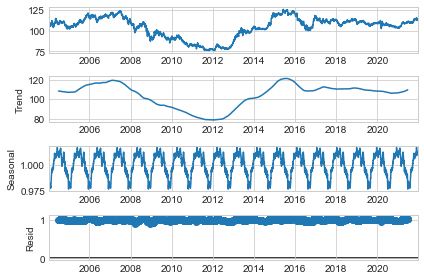

In [23]:
analysisData = pd.DataFrame()
analysisData["Price"] = exploreData['Price'] 
decompose_result_mult = seasonal_decompose(analysisData, period=253, model="muliplicitive")
decompose_result_mult.plot();

<AxesSubplot:xlabel='Date'>

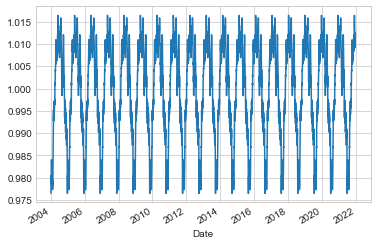

In [24]:
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

seasonal.plot()

**I found the most seasonality with a year based period and it appears to alternate yearly.**

### Predictive Modeling

#### Data Preprocessing

In [25]:
#Split Testing, Validation, and Training Data
start = datetime.datetime(2004, 1, 1,0,0)
end = datetime.datetime(2018, 12, 31, 0, 0)
trainData = featureData.loc[start:end]
trainData.describe()

,Price,Open,Price_DB,Open_DB,High_DB,Low_DB,Price_Average_Week,Price_Average_Month,Price_Average_3Month,Price_Average_Year,...,Price_STDRatio_3Month_Year,Day_Return,Week_Return,Month_Return,Quarter_Return,Year_Return,Day_Return_Week_AVG,Day_Return_Month_AVG,Day_Return_3Month_AVG,Day_Return_Year_AVG
count,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,...,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000
mean,103.504919,103.489990,103.504057,103.488920,103.959483,102.990200,103.502085,103.492580,103.467933,103.566171,...,0.529989,0.000030,0.000137,0.000626,0.001854,0.002091,0.000029,0.000032,0.000031,0.000009
std,13.216641,13.208551,13.216355,13.208158,13.249516,13.174586,13.202888,13.158803,13.043041,12.599933,...,0.271239,0.006472,0.013737,0.027780,0.049838,0.102077,0.002748,0.001317,0.000781,0.000391
min,75.820000,75.760000,75.820000,75.760000,76.000000,75.580000,76.060000,76.630000,76.852063,78.568135,...,0.096009,-0.037020,-0.087259,-0.121583,-0.187453,-0.217566,-0.018032,-0.006025,-0.003171,-0.000920
25%,93.740000,93.740000,93.740000,93.740000,94.380000,93.220000,93.832000,94.122381,93.727143,93.695079,...,0.325601,-0.003340,-0.007839,-0.016647,-0.029666,-0.073131,-0.001556,-0.000773,-0.000456,-0.000279
50%,106.670000,106.630000,106.670000,106.620000,107.060000,106.080000,106.646000,106.755714,107.076667,108.233532,...,0.471439,0.000084,0.000345,0.000264,0.000446,-0.010186,0.000078,0.000028,0.000024,-0.000024
75%,113.440000,113.430000,113.440000,113.430000,113.910000,112.920000,113.402000,113.099524,112.938254,112.483690,...,0.684884,0.003454,0.008379,0.017500,0.027842,0.053824,0.001687,0.000840,0.000450,0.000223
max,125.620000,125.580000,125.620000,125.580000,125.860000,124.520000,124.724000,124.200476,123.704286,121.151032,...,1.479485,0.053541,0.072211,0.107954,0.178180,0.316824,0.014123,0.004957,0.002624,0.001111


In [26]:
trainData.head()

,Price,Open,Price_DB,Open_DB,High_DB,Low_DB,Price_Average_Week,Price_Average_Month,Price_Average_3Month,Price_Average_Year,...,Price_STDRatio_3Month_Year,Day_Return,Week_Return,Month_Return,Quarter_Return,Year_Return,Day_Return_Week_AVG,Day_Return_Month_AVG,Day_Return_3Month_AVG,Day_Return_Year_AVG
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-07,106.23,106.17,106.21,106.26,106.43,106.03,106.876,107.366667,108.476190,115.572817,...,0.222906,-0.000565,-0.008032,-0.010435,-0.027114,-0.098004,-0.001605,-0.000493,-0.000423,-0.000397
2004-01-08,106.19,106.15,106.23,106.17,106.45,105.88,106.648,107.331429,108.437619,115.526111,...,0.229387,0.000188,-0.010617,-0.006918,-0.022363,-0.099746,-0.002128,-0.000324,-0.000346,-0.000405
2004-01-09,106.61,106.13,106.19,106.15,106.26,106.08,106.392,107.232857,108.394444,115.478651,...,0.235209,-0.000377,-0.011910,-0.019121,-0.024975,-0.101227,-0.002389,-0.000916,-0.000389,-0.000411
2004-01-12,106.71,106.64,106.61,106.13,108.27,106.11,106.302,107.163810,108.358095,115.432103,...,0.238110,0.003955,-0.004203,-0.013418,-0.021028,-0.099121,-0.000835,-0.000640,-0.000325,-0.000402
2004-01-13,106.23,106.64,106.71,106.64,106.77,106.35,106.390,107.114286,108.313333,115.387024,...,0.238496,0.000938,0.004140,-0.009652,-0.025746,-0.096214,0.000828,-0.000459,-0.000401,-0.000389


In [27]:
start = datetime.datetime(2019, 1, 1,0,0)
end = datetime.datetime(2020, 6, 15, 0, 0)
valData = featureData.loc[start:end]
valData.describe()

,Price,Open,Price_DB,Open_DB,High_DB,Low_DB,Price_Average_Week,Price_Average_Month,Price_Average_3Month,Price_Average_Year,...,Price_STDRatio_3Month_Year,Day_Return,Week_Return,Month_Return,Quarter_Return,Year_Return,Day_Return_Week_AVG,Day_Return_Month_AVG,Day_Return_3Month_AVG,Day_Return_Year_AVG
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,...,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,108.813711,108.824684,108.819684,108.832868,109.151500,108.455816,108.838268,108.920603,109.227066,109.876189,...,0.686158,-0.000058,-0.000323,-0.002134,-0.007059,-0.012914,-0.000064,-0.000095,-0.000103,-0.000045
std,1.612724,1.613279,1.611343,1.613565,1.528147,1.707545,1.541195,1.406335,1.409801,1.042261,...,0.305011,0.005105,0.011159,0.016152,0.021554,0.028317,0.002237,0.000773,0.000342,0.000113
min,102.340000,102.380000,102.340000,102.380000,104.930000,101.180000,104.486000,106.136667,107.164127,108.163373,...,0.250606,-0.028110,-0.055032,-0.067262,-0.057122,-0.076437,-0.011204,-0.003273,-0.000917,-0.000307
25%,107.755000,107.755000,107.760000,107.760000,108.077500,107.395000,107.801500,107.827619,108.040913,109.010149,...,0.455565,-0.001972,-0.005443,-0.011036,-0.025511,-0.035631,-0.001086,-0.000509,-0.000400,-0.000134
50%,108.670000,108.700000,108.675000,108.710000,108.975000,108.440000,108.698000,108.865952,108.988016,110.051071,...,0.590900,0.000000,0.000138,0.000140,-0.007903,-0.017629,0.000032,0.000012,-0.000111,-0.000062
75%,109.815000,109.832500,109.815000,109.842500,110.037500,109.552500,109.831500,109.773214,110.400794,110.847788,...,0.866880,0.002185,0.005867,0.008021,0.010674,0.003317,0.001173,0.000390,0.000175,0.000021
max,112.170000,112.180000,112.170000,112.180000,112.410000,111.920000,112.010000,112.160476,112.722540,111.330992,...,1.425665,0.032148,0.057918,0.062146,0.066347,0.063204,0.011483,0.002966,0.001055,0.000250


In [28]:
start = datetime.datetime(2020, 6, 16,0,0)
end = datetime.datetime(2021, 12, 13, 0, 0)
testData = featureData.loc[start:end]
testData.describe()

,Price,Open,Price_DB,Open_DB,High_DB,Low_DB,Price_Average_Week,Price_Average_Month,Price_Average_3Month,Price_Average_Year,...,Price_STDRatio_3Month_Year,Day_Return,Week_Return,Month_Return,Quarter_Return,Year_Return,Day_Return_Week_AVG,Day_Return_Month_AVG,Day_Return_3Month_AVG,Day_Return_Year_AVG
count,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,...,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000
mean,108.073734,108.073095,108.057928,108.057289,108.362916,107.771355,108.025749,107.912760,107.583210,107.173166,...,0.505176,0.000149,0.000726,0.003033,0.007719,0.008410,0.000146,0.000146,0.000124,0.000040
std,3.157642,3.145973,3.145906,3.134090,3.153975,3.116475,3.103973,2.946869,2.448495,0.914400,...,0.276533,0.003520,0.007459,0.013578,0.024459,0.043904,0.001491,0.000641,0.000382,0.000167
min,102.720000,102.750000,102.720000,102.750000,103.190000,102.580000,103.060000,103.460476,103.923810,105.888294,...,0.180507,-0.017685,-0.023048,-0.027891,-0.039025,-0.067369,-0.004629,-0.001342,-0.000621,-0.000260
25%,105.385000,105.395000,105.385000,105.395000,105.685000,105.105000,105.380000,105.431429,105.482143,106.287440,...,0.325283,-0.001830,-0.004091,-0.006619,-0.012733,-0.025410,-0.000814,-0.000312,-0.000197,-0.000089
50%,108.380000,108.380000,108.340000,108.150000,108.780000,108.010000,108.202000,107.731905,107.341587,107.144960,...,0.412114,0.000091,0.000386,-0.000091,0.002192,0.006641,0.000084,0.000006,0.000041,0.000034
75%,110.065000,110.015000,110.040000,110.000000,110.345000,109.735000,109.964000,109.891905,109.854603,107.997242,...,0.605795,0.002363,0.005280,0.009142,0.028909,0.036076,0.001056,0.000440,0.000460,0.000147
max,115.410000,115.420000,115.410000,115.420000,115.530000,115.240000,114.944000,114.117143,113.008254,109.464881,...,1.348723,0.019646,0.021918,0.046241,0.077784,0.109072,0.004352,0.002161,0.001194,0.000416


In [29]:
#Reformating for Models
X_train = trainData.drop('Price', axis='columns')
y_train = trainData.Price

X_test = valData.drop('Price', axis='columns')
y_test = valData.Price

In [30]:
#Scaling the Data
#Fit Scalar using training
scaler = StandardScaler()
scaler.fit(X_train)

#Rescale both using the fit scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

#### Linear Regression

In [31]:
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.548
MAE: 0.351
R^2: 0.884


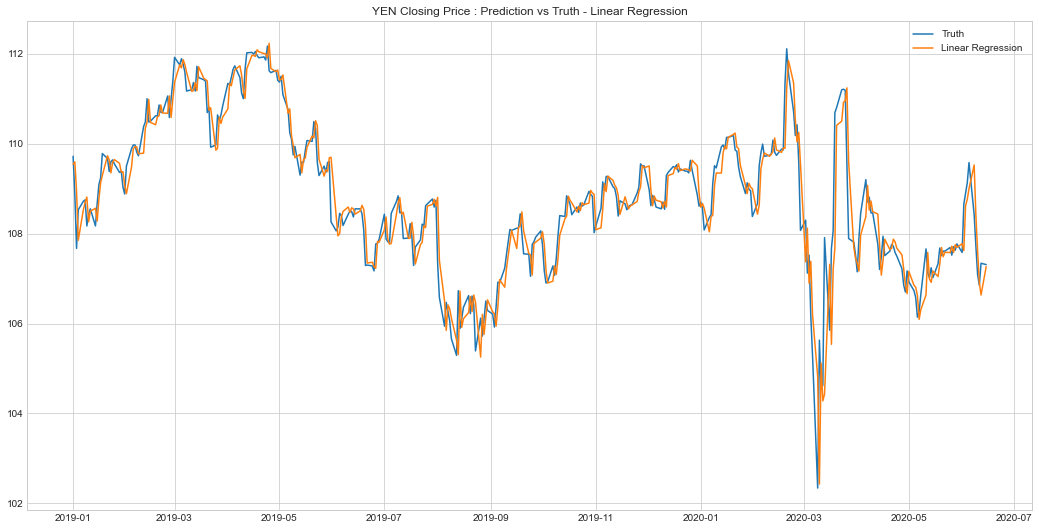

In [32]:
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('YEN Closing Price : Prediction vs Truth - Linear Regression')
plt.show()

#### SGD Regressor

In [33]:
param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 1e-05, 'eta0': 0.03, 'penalty': 'l2'}
RMSE: 0.581
MAE: 0.380
R^2: 0.870


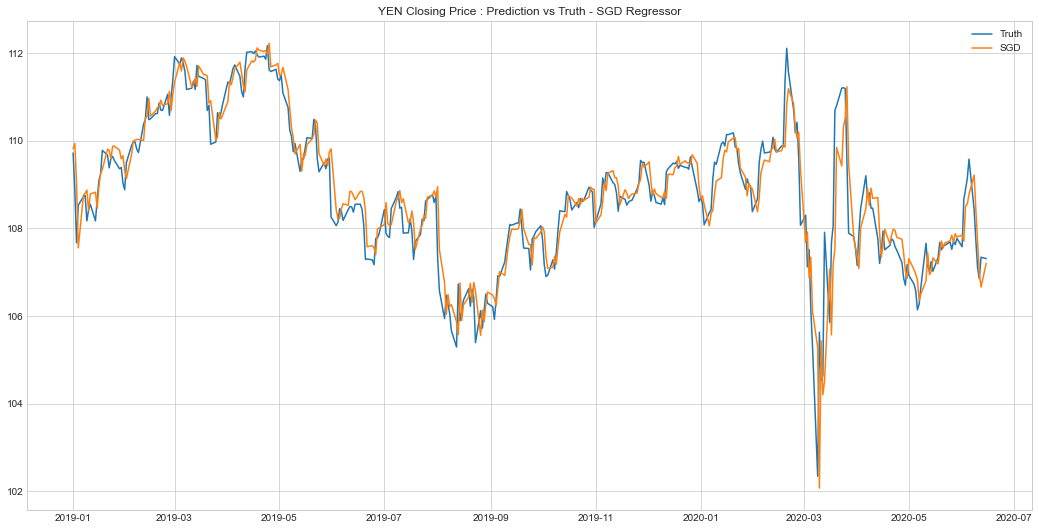

In [34]:
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('YEN Closing Price : Prediction vs Truth - SGD Regressor')
plt.show()

#### Extreme Gradient Boosting Regressor

In [35]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1}
RMSE: 0.581
MAE: 0.402
R^2: 0.870


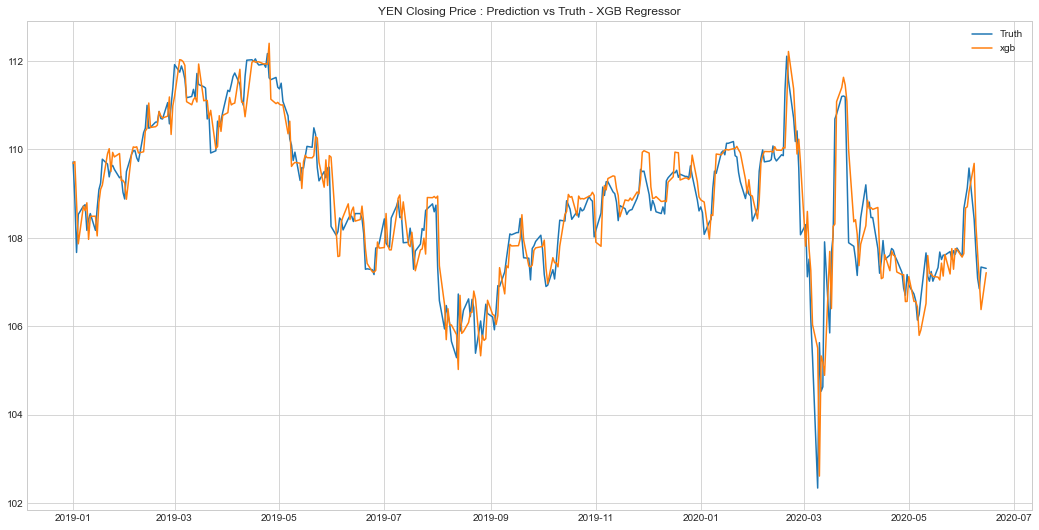

In [36]:
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('YEN Closing Price : Prediction vs Truth - XGB Regressor')
plt.show()

#### Bagging Regressor

In [37]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.548
MAE: 0.351
R^2: 0.884


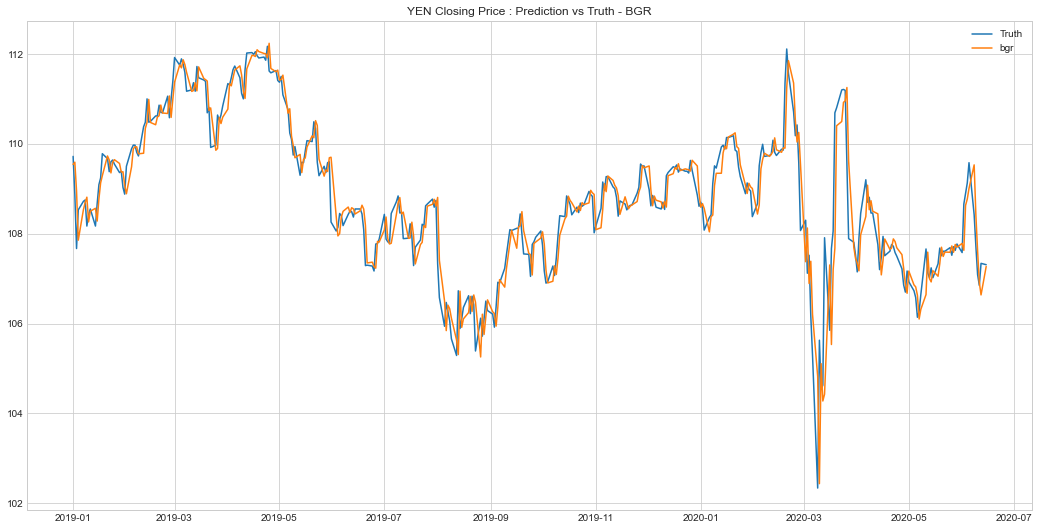

In [38]:
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('YEN Closing Price : Prediction vs Truth - BGR')
plt.show()

#### Random Forest Regressor

In [39]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))

{'max_depth': 30, 'min_samples_split': 20}
RMSE: 0.588
MAE: 0.401
R^2: 0.867


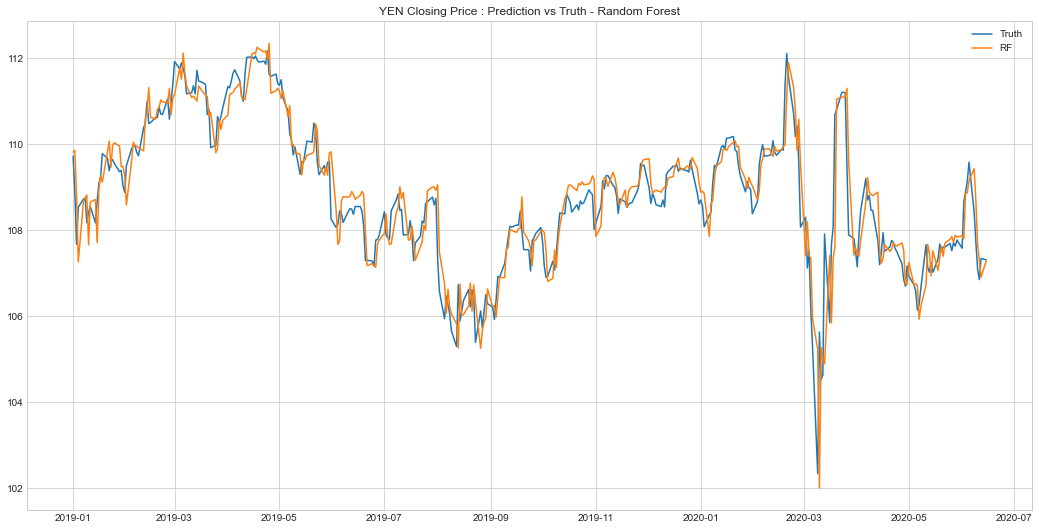

In [40]:
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('YEN Closing Price : Prediction vs Truth - Random Forest')
plt.show()

#### Final Scoring

The model with the least mean_absolute_error:
 LIN    0.350696
dtype: float64


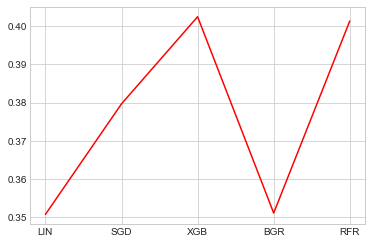

In [41]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')

In [42]:
#Simulating Test Trading Situation with Test Data
#Formatting and Scaling
X_test = testData.drop('Price', axis='columns')
y_test = testData.Price
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled_test = scaler.transform(X_test)

cash = 100
predictions_bgr = bgr.predict(X_scaled_test)

for d in range(0,50,2):
    cash = 100
    for i in range(0,len(y_test)):
        if (predictions_bgr[i] - X_test["Open"][i]) > d*.01:
            cash += (cash*((y_test[i]-X_test["Open"][i])/X_test["Open"][i]))
    print(d, cash)

0 103.71129592777996
2 103.61148458703217
4 101.14913883789028
6 100.88187960862913
8 99.67959051537116
10 100.17477234859017
12 99.95407957036167
14 100
16 100
18 100
20 100
22 100
24 100
26 100
28 100
30 100
32 100
34 100
36 100
38 100
40 100
42 100
44 100
46 100
48 100


### Objective 3
Incorporate useful explanatory data into the predictive models, such as information on weather and
physical commodity production

#### What am I adding?
In order to get more information on what other currencies are doing, I am incorporating 3 more currencies: EUR, GBP, and CAD. All 4 are major US trading partners, so my thinking is they should be connected in some way.

In [43]:
#Read in Historical Data
datasetEUR = pd.read_csv('USD_EUR Historical Data.csv')
datasetGBP = pd.read_csv('USD_GBP Historical Data.csv')
datasetCAD = pd.read_csv('USD_CAD Historical Data.csv')


#Convert Dates to Datetime format and set that as the index
datasetEUR['Date'] = pd.to_datetime(datasetEUR['Date'])
datasetEUR = datasetEUR.set_index('Date')
datasetEUR = datasetEUR.sort_index()
datasetGBP['Date'] = pd.to_datetime(datasetGBP['Date'])
datasetGBP = datasetGBP.set_index('Date')
datasetGBP = datasetGBP.sort_index()
datasetCAD['Date'] = pd.to_datetime(datasetCAD['Date'])
datasetCAD = datasetCAD.set_index('Date')
datasetCAD = datasetCAD.sort_index()

#Convert Change % from string to float
datasetEUR['Change %'] = datasetEUR["Change %"].str.replace(r"[^0-9.-]",'').astype(float)
datasetEUR['Change %'] = datasetEUR["Change %"]/100
datasetGBP['Change %'] = datasetGBP["Change %"].str.replace(r"[^0-9.-]",'').astype(float)
datasetGBP['Change %'] = datasetGBP["Change %"]/100
datasetCAD['Change %'] = datasetCAD["Change %"].str.replace(r"[^0-9.-]",'').astype(float)
datasetCAD['Change %'] = datasetCAD["Change %"]/100

<ipython-input-43-9fbf740f830e>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  datasetEUR['Change %'] = datasetEUR["Change %"].str.replace(r"[^0-9.-]",'').astype(float)
<ipython-input-43-9fbf740f830e>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  datasetGBP['Change %'] = datasetGBP["Change %"].str.replace(r"[^0-9.-]",'').astype(float)
<ipython-input-43-9fbf740f830e>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  datasetCAD['Change %'] = datasetCAD["Change %"].str.replace(r"[^0-9.-]",'').astype(float)


No handles with labels found to put in legend.


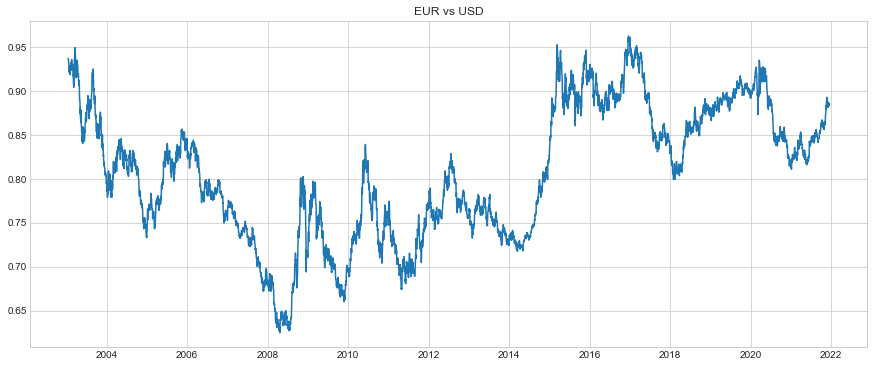

In [44]:
plt.figure(figsize=(15,6))
plt.plot(datasetEUR.Price)
plt.title('EUR vs USD')
plt.legend()
plt.show()

No handles with labels found to put in legend.


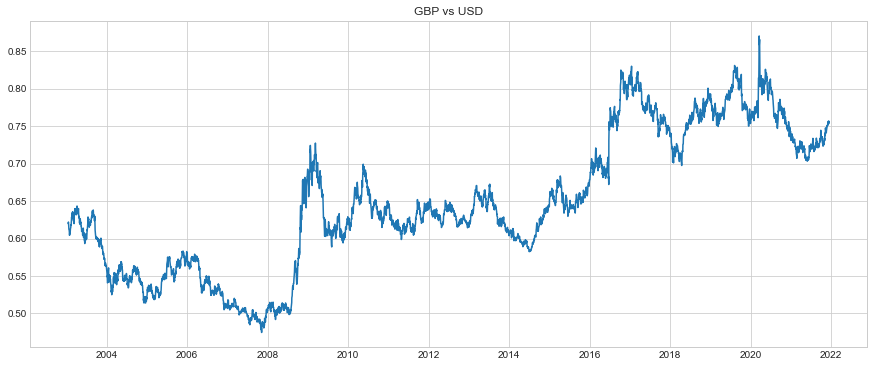

In [45]:
plt.figure(figsize=(15,6))
plt.plot(datasetGBP.Price)
plt.title('GBP vs USD')
plt.legend()
plt.show()

No handles with labels found to put in legend.


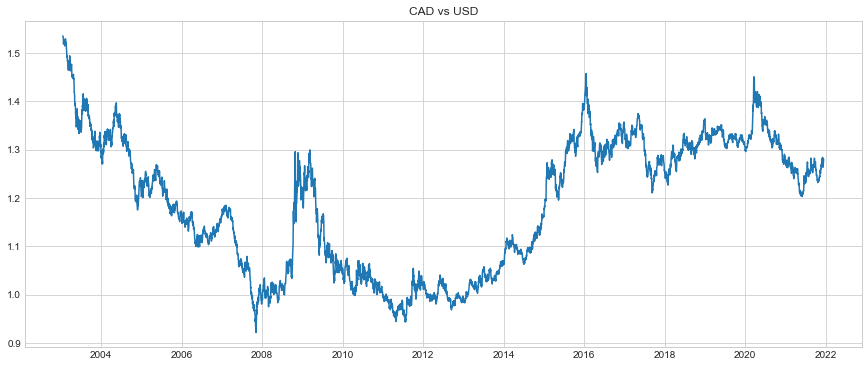

In [46]:
plt.figure(figsize=(15,6))
plt.plot(datasetCAD.Price)
plt.title('CAD vs USD')
plt.legend()
plt.show()

In [47]:
#For Redundency Sake, Ill just make the addFeatures section a method
def addFeatures(dataset, currencyName):
    featureData = pd.DataFrame()

    #Add Original Features
    featureData[currencyName + '_Price'] = dataset['Price']
    featureData[currencyName + '_Open'] = dataset['Open']

    #Add Day Before Features
    featureData[currencyName + '_Price_DB'] = dataset['Price'].shift(1)
    featureData[currencyName + '_Open_DB'] = dataset['Open'].shift(1)
    featureData[currencyName + '_High_DB'] = dataset['High'].shift(1)
    featureData[currencyName + '_Low_DB'] = dataset['Low'].shift(1)

    #Add Price Average Windows
    featureData[currencyName + '_Price_Average_Week'] = dataset['Price'].rolling(window=5).mean().shift(1)
    featureData[currencyName + '_Price_Average_Month'] = dataset['Price'].rolling(window=21).mean().shift(1)
    featureData[currencyName + '_Price_Average_3Month'] = dataset['Price'].rolling(window=63).mean().shift(1)
    featureData[currencyName + '_Price_Average_Year'] = dataset['Price'].rolling(window=252).mean().shift(1)

    #Add Price Average Ratios
    featureData[currencyName + '_Price_AVGRatio_Week_Month'] = featureData[currencyName + '_Price_Average_Week']/featureData[currencyName + '_Price_Average_Month']
    featureData[currencyName + '_Price_AVGRatio_Week_3Month'] = featureData[currencyName + '_Price_Average_Week']/featureData[currencyName + '_Price_Average_3Month']
    featureData[currencyName + '_Price_AVGRatio_Week_Year'] = featureData[currencyName + '_Price_Average_Week']/featureData[currencyName + '_Price_Average_Year']
    featureData[currencyName + '_Price_AVGRatio_Month_3Month'] = featureData[currencyName + '_Price_Average_Month']/featureData[currencyName + '_Price_Average_3Month']
    featureData[currencyName + '_Price_AVGRatio_Month_Year'] = featureData[currencyName + '_Price_Average_Month']/featureData[currencyName + '_Price_Average_Year']
    featureData[currencyName + '_Price_AVGRatio_3Month_Year'] = featureData[currencyName + '_Price_Average_3Month']/featureData[currencyName + '_Price_Average_Year']

    #Add Price Standard Deviations
    featureData[currencyName + '_Price_STD_Week'] = dataset['Price'].rolling(window=5).std().shift(1)
    featureData[currencyName + '_Price_STD_Month'] = dataset['Price'].rolling(window=21).std().shift(1)
    featureData[currencyName + '_Price_STD_3Month'] = dataset['Price'].rolling(window=63).std().shift(1)
    featureData[currencyName + '_Price_STD_Year'] = dataset['Price'].rolling(window=252).std().shift(1)

    #Add Price Standard Deviations Ratios
    featureData[currencyName + '_Price_STDRatio_Week_Month'] = featureData[currencyName + '_Price_STD_Week']/featureData[currencyName + '_Price_STD_Month']
    featureData[currencyName + '_Price_STDRatio_Week_3Month'] = featureData[currencyName + '_Price_STD_Week']/featureData[currencyName + '_Price_STD_3Month']
    featureData[currencyName + '_Price_STDRatio_Week_Year'] = featureData[currencyName + '_Price_STD_Week']/featureData[currencyName + '_Price_STD_Year']
    featureData[currencyName + '_Price_STDRatio_Month_3Month'] = featureData[currencyName + '_Price_STD_Month']/featureData[currencyName + '_Price_STD_3Month']
    featureData[currencyName + '_Price_STDRatio_Month_Year'] = featureData[currencyName + '_Price_STD_Month']/featureData[currencyName + '_Price_STD_Year']
    featureData[currencyName + '_Price_STDRatio_3Month_Year'] = featureData[currencyName + '_Price_STD_3Month']/featureData[currencyName + '_Price_STD_Year']

    #Add Daily, Weekly, Monthly, Quarterly, and Yearly Returns
    featureData[currencyName + '_Day_Return'] = ((dataset['Price']-dataset['Price'].shift(1))/dataset['Price'].shift(1)).shift(1)
    featureData[currencyName + '_Week_Return'] = ((dataset['Price']-dataset['Price'].shift(5))/dataset['Price'].shift(5)).shift(1)
    featureData[currencyName + '_Month_Return'] = ((dataset['Price']-dataset['Price'].shift(21))/dataset['Price'].shift(21)).shift(1)
    featureData[currencyName + '_Quarter_Return'] = ((dataset['Price']-dataset['Price'].shift(63))/dataset['Price'].shift(63)).shift(1)
    featureData[currencyName + '_Year_Return'] = ((dataset['Price']-dataset['Price'].shift(252))/dataset['Price'].shift(252)).shift(1)

    #Add Average of Daily Return
    featureData[currencyName + '_Day_Return_Week_AVG'] = featureData[currencyName + '_Day_Return'].rolling(window=5).mean()
    featureData[currencyName + '_Day_Return_Month_AVG'] = featureData[currencyName + '_Day_Return'].rolling(window=21).mean()
    featureData[currencyName + '_Day_Return_3Month_AVG'] = featureData[currencyName + '_Day_Return'].rolling(window=63).mean()
    featureData[currencyName + '_Day_Return_Year_AVG'] = featureData[currencyName + '_Day_Return'].rolling(window=252).mean()

    featureData = featureData.dropna(axis=0)
    return featureData

In [48]:
#Calling for All Currencies (I added Yen so I would get the column name change easily)
allCurrenciesData = addFeatures(dataset, "YEN")
allCurrenciesData = allCurrenciesData.join(addFeatures(datasetEUR, "EUR"))
allCurrenciesData = allCurrenciesData.join(addFeatures(datasetGBP, "GBP"))
allCurrenciesData = allCurrenciesData.join(addFeatures(datasetCAD, "CAD"))

In [49]:
allCurrenciesData.describe()

,YEN_Price,YEN_Open,YEN_Price_DB,YEN_Open_DB,YEN_High_DB,YEN_Low_DB,YEN_Price_Average_Week,YEN_Price_Average_Month,YEN_Price_Average_3Month,YEN_Price_Average_Year,...,CAD_Price_STDRatio_3Month_Year,CAD_Day_Return,CAD_Week_Return,CAD_Month_Return,CAD_Quarter_Return,CAD_Year_Return,CAD_Day_Return_Week_AVG,CAD_Day_Return_Month_AVG,CAD_Day_Return_3Month_AVG,CAD_Day_Return_Year_AVG
count,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,...,4679.000000,4679.000000,4679.000000,4679.000000,4679.000000,4679.000000,4679.000000,4679.000000,4679.000000,4679.000000
mean,104.317686,104.306053,104.316130,104.304504,104.748951,103.833440,104.313303,104.302610,104.279374,104.379877,...,0.536648,0.000015,0.000063,0.000161,0.000336,-0.001980,0.000013,0.000009,0.000007,-0.000006
std,12.260111,12.253724,12.259409,12.253018,12.281179,12.232741,12.245507,12.201444,12.091303,11.679665,...,0.245449,0.005671,0.012604,0.024896,0.042971,0.086153,0.002518,0.001176,0.000679,0.000337
min,75.820000,75.760000,75.820000,75.760000,76.000000,75.580000,76.060000,76.630000,76.852063,78.568135,...,0.152427,-0.036955,-0.095219,-0.086516,-0.160887,-0.209844,-0.019692,-0.004260,-0.002742,-0.000879
25%,98.085000,98.052500,98.085000,98.052500,98.632500,97.387500,98.021000,98.029762,98.253651,98.103016,...,0.365686,-0.003149,-0.007309,-0.014982,-0.025318,-0.057922,-0.001454,-0.000701,-0.000394,-0.000222
50%,107.630000,107.620000,107.630000,107.610000,108.000000,107.185000,107.634000,107.654048,107.557143,108.239901,...,0.488428,0.000000,-0.000263,-0.000900,-0.000699,-0.008465,-0.000042,-0.000033,0.000003,-0.000022
75%,112.535000,112.500000,112.530000,112.500000,112.890000,112.052500,112.503000,112.344881,111.916190,111.524425,...,0.672573,0.003101,0.007013,0.014235,0.023484,0.042605,0.001410,0.000687,0.000386,0.000179
max,125.620000,125.580000,125.620000,125.580000,125.860000,124.520000,124.724000,124.200476,123.704286,121.151032,...,1.755614,0.033449,0.089061,0.254063,0.267182,0.387052,0.017306,0.010931,0.003823,0.001332


<AxesSubplot:>

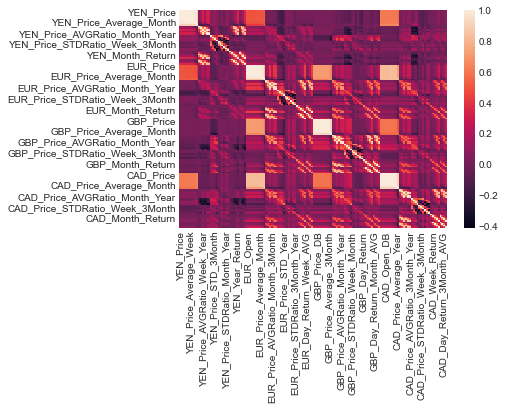

In [50]:
sns.heatmap(allCurrenciesData.corr())

#### Data Preprocessing

In [51]:
#Split Testing, Validation, and Training Data
start = datetime.datetime(2004, 1, 1,0,0)
end = datetime.datetime(2018, 12, 31, 0, 0)
trainData = allCurrenciesData.loc[start:end]
trainData.describe()

,YEN_Price,YEN_Open,YEN_Price_DB,YEN_Open_DB,YEN_High_DB,YEN_Low_DB,YEN_Price_Average_Week,YEN_Price_Average_Month,YEN_Price_Average_3Month,YEN_Price_Average_Year,...,CAD_Price_STDRatio_3Month_Year,CAD_Day_Return,CAD_Week_Return,CAD_Month_Return,CAD_Quarter_Return,CAD_Year_Return,CAD_Day_Return_Week_AVG,CAD_Day_Return_Month_AVG,CAD_Day_Return_3Month_AVG,CAD_Day_Return_Year_AVG
count,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,...,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3909.000000,3.909000e+03
mean,103.504919,103.489990,103.504057,103.488920,103.959483,102.990200,103.502085,103.492580,103.467933,103.566171,...,0.526817,0.000034,0.000156,0.000467,0.001123,-0.000368,0.000031,0.000024,0.000020,8.162672e-08
std,13.216641,13.208551,13.216355,13.208158,13.249516,13.174586,13.202888,13.158803,13.043041,12.599933,...,0.236184,0.005903,0.013149,0.025905,0.045006,0.091583,0.002627,0.001223,0.000711,3.575190e-04
min,75.820000,75.760000,75.820000,75.760000,76.000000,75.580000,76.060000,76.630000,76.852063,78.568135,...,0.152427,-0.036955,-0.095219,-0.086516,-0.160887,-0.209844,-0.019692,-0.004260,-0.002742,-8.793052e-04
25%,93.740000,93.740000,93.740000,93.740000,94.380000,93.220000,93.832000,94.122381,93.727143,93.695079,...,0.360337,-0.003332,-0.007740,-0.015317,-0.025943,-0.061375,-0.001543,-0.000721,-0.000405,-2.382166e-04
50%,106.670000,106.630000,106.670000,106.620000,107.060000,106.080000,106.646000,106.755714,107.076667,108.233532,...,0.472098,0.000000,-0.000200,-0.000396,0.001698,-0.014257,-0.000031,-0.000007,0.000039,-4.367321e-05
75%,113.440000,113.430000,113.440000,113.430000,113.910000,112.920000,113.402000,113.099524,112.938254,112.483690,...,0.672588,0.003213,0.007697,0.015379,0.025752,0.048811,0.001552,0.000739,0.000420,2.027218e-04
max,125.620000,125.580000,125.620000,125.580000,125.860000,124.520000,124.724000,124.200476,123.704286,121.151032,...,1.539959,0.033449,0.089061,0.254063,0.267182,0.387052,0.017306,0.010931,0.003823,1.332075e-03


In [52]:
start = datetime.datetime(2019, 1, 1,0,0)
end = datetime.datetime(2020, 6, 15, 0, 0)
valData = allCurrenciesData.loc[start:end]
valData.describe()

,YEN_Price,YEN_Open,YEN_Price_DB,YEN_Open_DB,YEN_High_DB,YEN_Low_DB,YEN_Price_Average_Week,YEN_Price_Average_Month,YEN_Price_Average_3Month,YEN_Price_Average_Year,...,CAD_Price_STDRatio_3Month_Year,CAD_Day_Return,CAD_Week_Return,CAD_Month_Return,CAD_Quarter_Return,CAD_Year_Return,CAD_Day_Return_Week_AVG,CAD_Day_Return_Month_AVG,CAD_Day_Return_3Month_AVG,CAD_Day_Return_Year_AVG
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,...,380.000000,3.800000e+02,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,108.813711,108.824684,108.819684,108.832868,109.151500,108.455816,108.838268,108.920603,109.227066,109.876189,...,0.742749,-7.913753e-07,-0.000065,0.001293,0.009531,0.022401,-0.000014,0.000061,0.000153,0.000094
std,1.612724,1.613279,1.611343,1.613565,1.528147,1.707545,1.541195,1.406335,1.409801,1.042261,...,0.303948,4.489202e-03,0.010412,0.020638,0.028961,0.027371,0.002079,0.000972,0.000452,0.000107
min,102.340000,102.380000,102.340000,102.380000,104.930000,101.180000,104.486000,106.136667,107.164127,108.163373,...,0.334996,-1.860433e-02,-0.034045,-0.047311,-0.043383,-0.038495,-0.006858,-0.002291,-0.000675,-0.000151
25%,107.755000,107.755000,107.760000,107.760000,108.077500,107.395000,107.801500,107.827619,108.040913,109.010149,...,0.577358,-2.160998e-03,-0.005206,-0.010303,-0.009003,0.000415,-0.001036,-0.000488,-0.000140,0.000008
50%,108.670000,108.700000,108.675000,108.710000,108.975000,108.440000,108.698000,108.865952,108.988016,110.051071,...,0.663303,0.000000e+00,-0.000378,-0.000934,0.002160,0.019754,-0.000073,-0.000038,0.000037,0.000084
75%,109.815000,109.832500,109.815000,109.842500,110.037500,109.552500,109.831500,109.773214,110.400794,110.847788,...,0.802236,1.958868e-03,0.005260,0.010418,0.016703,0.043147,0.001052,0.000497,0.000269,0.000176
max,112.170000,112.180000,112.170000,112.180000,112.410000,111.920000,112.010000,112.160476,112.722540,111.330992,...,1.755614,2.140996e-02,0.052773,0.097745,0.104010,0.094886,0.010391,0.004480,0.001585,0.000369


In [53]:
start = datetime.datetime(2020, 6, 16,0,0)
end = datetime.datetime(2021, 12, 13, 0, 0)
testData = allCurrenciesData.loc[start:end]
testData.describe()

,YEN_Price,YEN_Open,YEN_Price_DB,YEN_Open_DB,YEN_High_DB,YEN_Low_DB,YEN_Price_Average_Week,YEN_Price_Average_Month,YEN_Price_Average_3Month,YEN_Price_Average_Year,...,CAD_Price_STDRatio_3Month_Year,CAD_Day_Return,CAD_Week_Return,CAD_Month_Return,CAD_Quarter_Return,CAD_Year_Return,CAD_Day_Return_Week_AVG,CAD_Day_Return_Month_AVG,CAD_Day_Return_3Month_AVG,CAD_Day_Return_Year_AVG
count,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,...,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,108.073734,108.073095,108.057928,108.057289,108.362916,107.771355,108.025749,107.912760,107.583210,107.173166,...,0.434373,-0.000160,-0.000738,-0.004010,-0.016515,-0.041899,-0.000146,-0.000189,-0.000260,-0.000163
std,3.157642,3.145973,3.145906,3.134090,3.153975,3.116475,3.103973,2.946869,2.448495,0.914400,...,0.145324,0.004119,0.008195,0.016643,0.025801,0.045405,0.001640,0.000795,0.000412,0.000191
min,102.720000,102.750000,102.720000,102.750000,103.190000,102.580000,103.060000,103.460476,103.923810,105.888294,...,0.163694,-0.013727,-0.020716,-0.038705,-0.066713,-0.135415,-0.004172,-0.001872,-0.001071,-0.000569
25%,105.385000,105.395000,105.385000,105.395000,105.685000,105.105000,105.380000,105.431429,105.482143,106.287440,...,0.306592,-0.002689,-0.006390,-0.016171,-0.034459,-0.071673,-0.001277,-0.000770,-0.000548,-0.000286
50%,108.380000,108.380000,108.340000,108.150000,108.780000,108.010000,108.202000,107.731905,107.341587,107.144960,...,0.438196,-0.000240,-0.001117,-0.004931,-0.020602,-0.037818,-0.000218,-0.000228,-0.000320,-0.000141
75%,110.065000,110.015000,110.040000,110.000000,110.345000,109.735000,109.964000,109.891905,109.854603,107.997242,...,0.530768,0.002379,0.004867,0.006333,-0.005479,-0.007079,0.000987,0.000310,-0.000079,-0.000015
max,115.410000,115.420000,115.410000,115.420000,115.530000,115.240000,114.944000,114.117143,113.008254,109.464881,...,0.749420,0.013512,0.025257,0.035975,0.065371,0.046483,0.005007,0.001691,0.001016,0.000192


In [54]:
#Reformating for Models
X_train = trainData.drop('YEN_Price', axis='columns')
y_train = trainData.YEN_Price

X_test = valData.drop('YEN_Price', axis='columns')
y_test = valData.YEN_Price

#Scaling the Data
#Fit Scalar using training
scaler = StandardScaler()
scaler.fit(X_train)

#Rescale both using the fit scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

#### Linear Regression

RMSE: 0.532
MAE: 0.355
R^2: 0.891


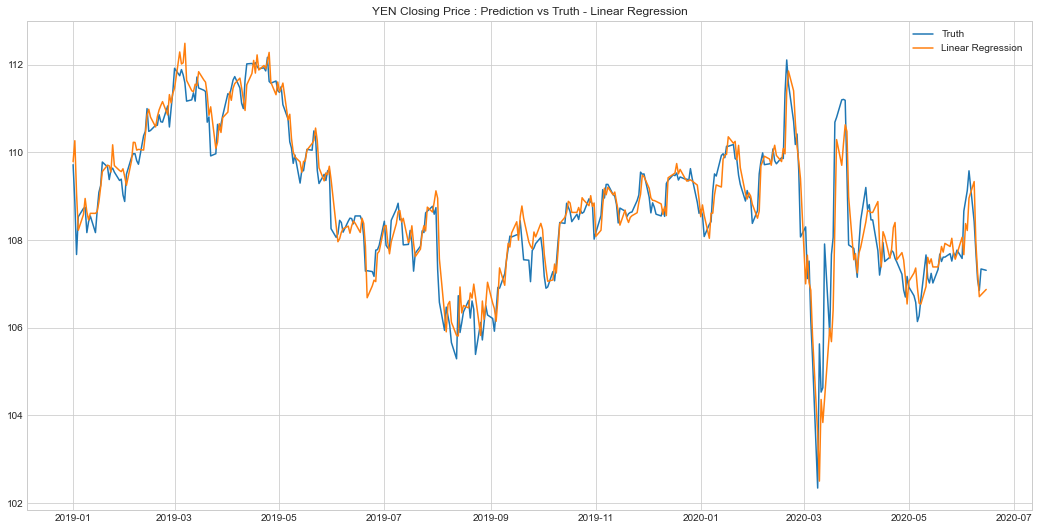

In [55]:
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('YEN Closing Price : Prediction vs Truth - Linear Regression')
plt.show()

#### SGD Regressor

{'alpha': 3e-05, 'eta0': 0.03, 'penalty': 'l1'}
RMSE: 0.681
MAE: 0.504
R^2: 0.821


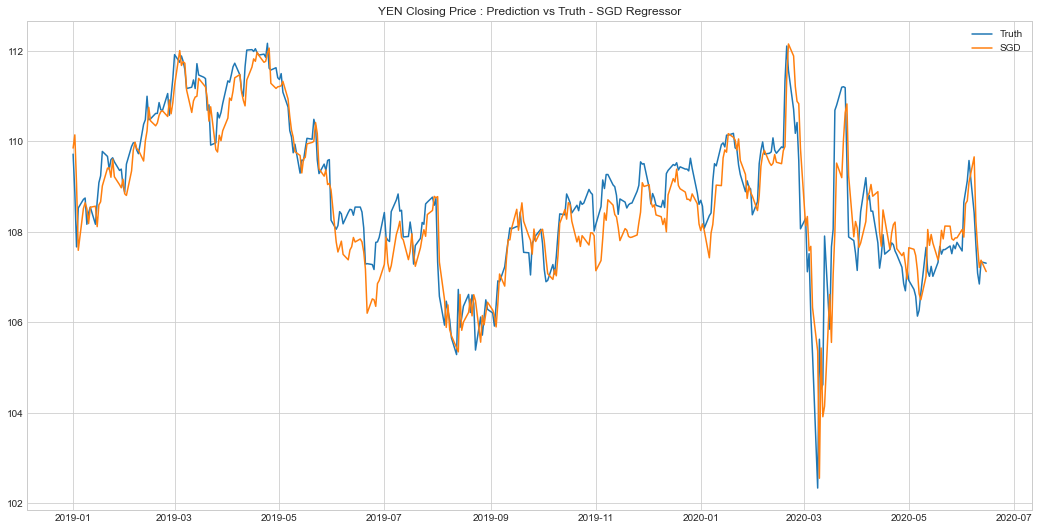

In [56]:
param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('YEN Closing Price : Prediction vs Truth - SGD Regressor')
plt.show()

#### XGB Regressor

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 1}
RMSE: 0.615
MAE: 0.440
R^2: 0.854


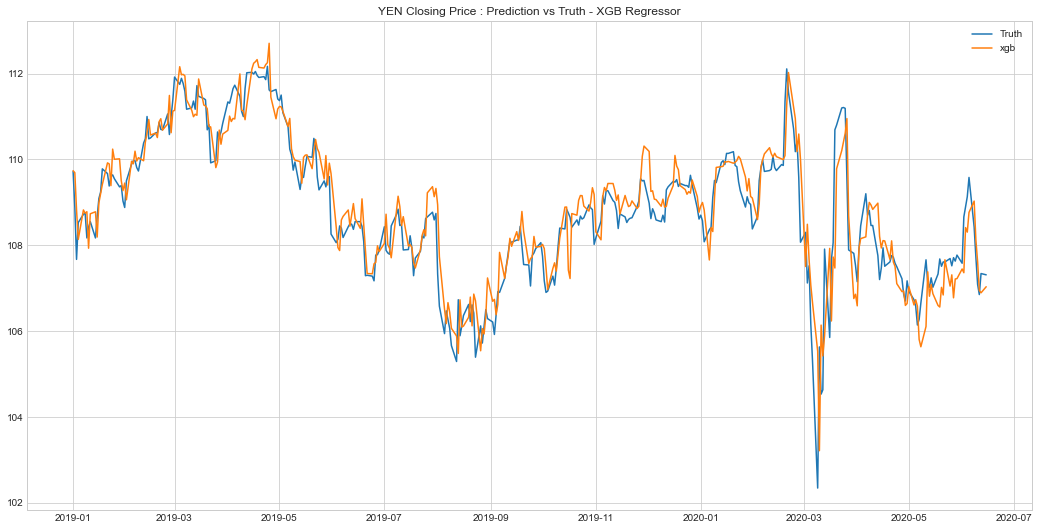

In [57]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('YEN Closing Price : Prediction vs Truth - XGB Regressor')
plt.show()

#### Bagging Regressor

OOB: 1.000
RMSE: 0.522
MAE: 0.349
R^2: 0.895


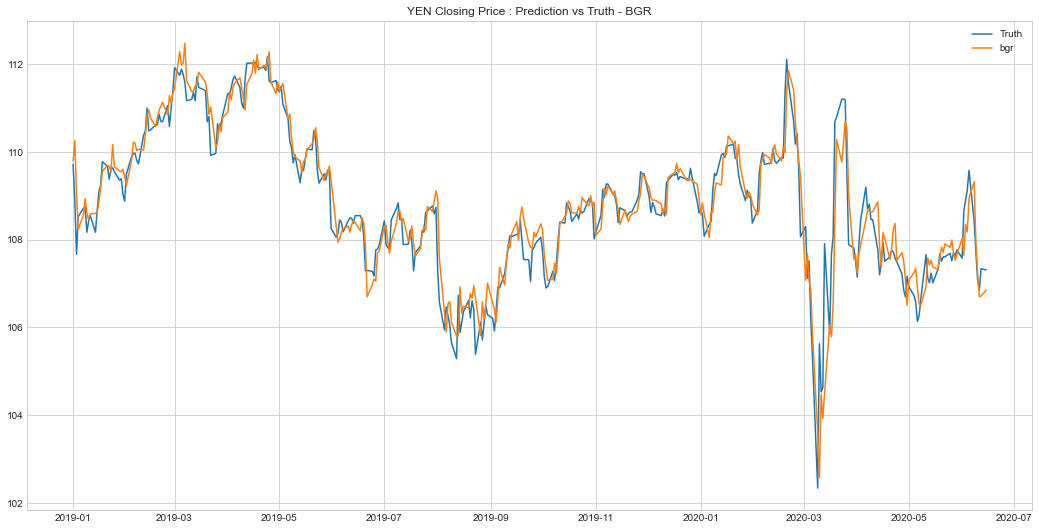

In [58]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('YEN Closing Price : Prediction vs Truth - BGR')
plt.show()

#### Random Forest

{'max_depth': 30, 'min_samples_split': 20}
RMSE: 0.681
MAE: 0.490
R^2: 0.821


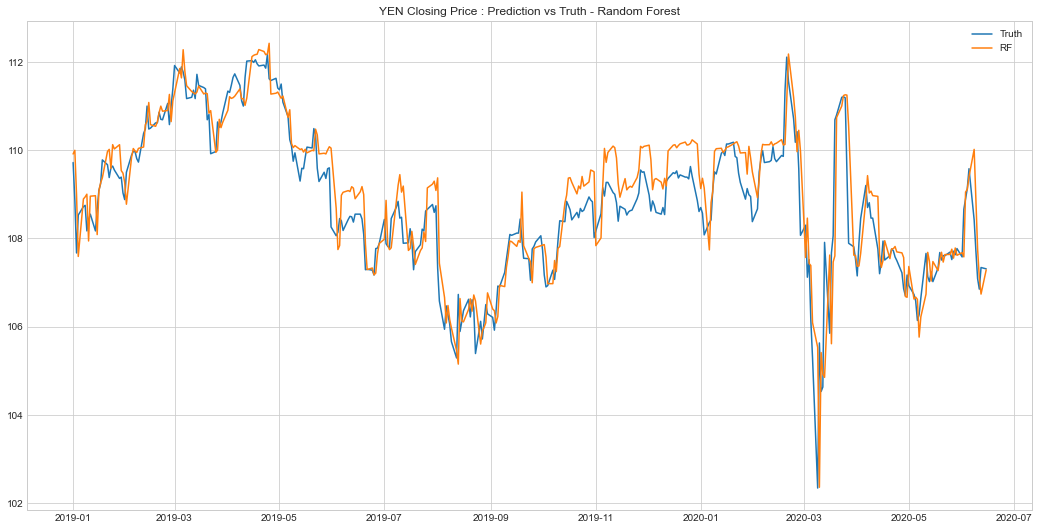

In [59]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))
dates = valData.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('YEN Closing Price : Prediction vs Truth - Random Forest')
plt.show()

#### Final Scoring

The model with the least mean_absolute_error:
 BGR    0.349115
dtype: float64


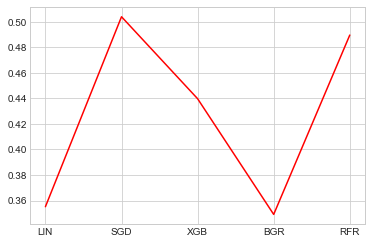

In [60]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')

#### Simulation Trading with Test Data

In [61]:
#Formatting and Scaling
testData = testData.dropna(axis=0)
X_test = testData.drop('YEN_Price', axis='columns')
y_test = testData.YEN_Price

scaler = StandardScaler()
scaler.fit(X_train)
X_scaled_test = scaler.transform(X_test)

predictions_bgr = bgr.predict(X_scaled_test)
cash = 100
for i in range(0,len(y_test)):
    if (predictions_bgr[i] - X_test["YEN_Open"][i]) > 0:
        cash += (cash*((y_test[i]-X_test["YEN_Open"][i])/X_test["YEN_Open"][i]))
print(cash)

120.37769614765067


### Outcome

The BGR algorithm performed better with other currencies included in the training showing they do offer more information for the algorithm to use
#### Confusion Matrix

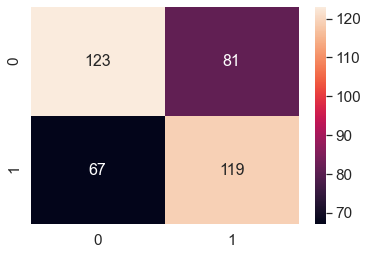

In [62]:
results = [[0,0],
          [0,0]]

for i in range(0,len(y_test)):
    x = 0
    y = 0
    if y_test[i] > X_test["YEN_Open"][i]:
        y = 1
    if predictions_bgr[i] > X_test["YEN_Open"][i]:
        x = 1
    results[y][x] += 1

df_cm = pd.DataFrame(results, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

plt.show()